### CS4102 - Geometric Foundations of Data Analysis I
Prof. Götz Pfeiffer<br />
School of Mathematics, Statistics and Applied Mathematics<br />
NUI Galway

#### 1. Least Squares Fitting

# Week 6

## 0. Questions

* How to compute the $r^2$ for the skin care example?
* How to compute simultaneous interval estimates?
* ...

##  Hypothesis Testing: Skin Care Example

* We apply the same procedure as before, to find the coefficient of determination for the data in the file `cream.csv`.
* We start by importing the packages (`csv` and `numpy`).

In [1]:
import csv
import numpy as np

In [2]:
with open('cream.csv') as csvfile:
    rows = list(csv.DictReader(csvfile))

* The main difference is that the data file now has one more column of $x$-values.

In [3]:
rows[0]

{'i': '1', 'y': '162', 'xone': '274', 'xtwo': '2450'}

* Still, we can build numpy arrays `X` and `Y`, representing the matrices $X$ and $Y$, in a similar fashion as before.

In [4]:
X = np.array([[1, row['xone'], row['xtwo']] for row in rows], dtype=float)
Y = np.array([[row['y']] for row in rows], dtype=float)

* The matrix formula for computing the coefficients $B = (b_0, b_1, b_2)^t$ of the least squares fit $y = b_0 + b_1 x_1 + b_2 x_2$ is still the same:
$$
  B = (X^t X)^{-1} X^t Y
$$
* And so is the sequence of steps used to compute it.

In [5]:
XtX = X.T @ X  # T for transpose, @ for matrix multiplication
XtY = X.T @ Y
B = np.linalg.inv(XtX) @ XtY
print(B)

[[3.44464247]
 [0.49600005]
 [0.00920093]]


* From this, we compute the ingredients for the quantities SSE, SSR and SSTO as before ...

In [6]:
Yhat = X @ B
ybar = sum(Y)/len(Y)
ybar = ybar[0]
BtXtY = B.T @ XtY
YtY = Y.T @ Y
nybar2 = len(Y) * ybar**2

* ... and then the quantities themselves.

In [7]:
SSR = BtXtY - nybar2
SSE = YtY - BtXtY
SSTO = YtY - nybar2
SSR = SSR[0,0]
SSE = SSE[0,0]
SSTO = SSTO[0,0]
print("SSR =", SSR, ", SSE =", SSE, ", SSTO =", SSTO)

SSR = 53844.60550034547 , SSE = 56.994499654567335 , SSTO = 53901.600000000035


* Finally $r^2 = \mathrm{SSR}/\mathrm{SSTO}$

In [8]:
r2 = SSR/SSTO
r2

0.9989426195204861

* Next, the F-test requires slightly modified quantities:
$$
\mathrm{MSR} = \frac{\mathrm{SSR}}{p-1}, \qquad
\mathrm{MSE} = \frac{\mathrm{SSE}}{n-p}, \qquad
F^* = \frac{\mathrm{MSR}}{\mathrm{MSE}}
$$
* Here, $p = 3$ and $n = 15$.
* Let's compute $F^*$!

In [9]:
n = len(X)
p = len(X[0])
print("n =", n, ", p =", p)
MSR = SSR/(p-1)
MSE = SSE/(n-p)
Fstar = MSR/MSE
Fstar

n = 15 , p = 3


5668.400195810533

* Then, assuming that the errors $\epsilon_i$ are independent $N(0, \sigma^2)$, we choose a confidence level $\alpha = 0.05$ and find the value of the $F$-distribution with $p-1$ and $n-p$ degrees of freedom.
* This value can be found in a table, online or off-line, or with the help of the `scipy.stats` package

In [10]:
from scipy.stats import f
alpha = 0.05
f.pdf(1 - alpha, p-1, n-p)

0.3574087005858445

* As this value is clearly smaller than $F^*$, we can reject the null hypothesis $\mathcal{C}_0$ at level $\alpha$.

* In order to quickly chek whether the $\epsilon_i$ are independent and normally distributed, we can plot them (i) against the actual error $\hat{y}_i$, (ii) against the input data $x_{i1}$, (iii) against the input data $x_{i2}$.
* The $x_{i1}$ reside in column $1$ of the array `X`, from where we can extract them as `X[:,1]`, using a *slice* (`:` for all) in the first dimension, and an index (`1` for column $1$) in the second dimension.

In [11]:
X[:,1]

array([274., 180., 375., 205.,  86., 265.,  98., 330., 195.,  53., 430.,
       372., 236., 157., 370.])

* For plotting, we use the `matplotlib.pyplot` package under its nickname `plt`.

In [12]:
import matplotlib.pyplot as plt

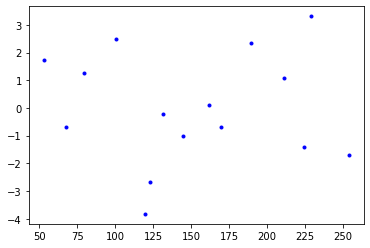

In [13]:
Yhat = X @ B
E = Y - Yhat
plt.plot(Yhat, E, 'b.')

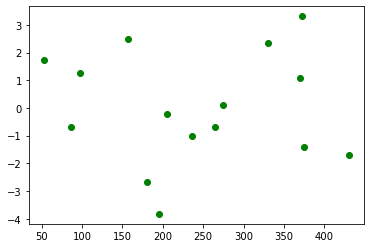

In [14]:
plt.plot(X[:,1], E, 'go')

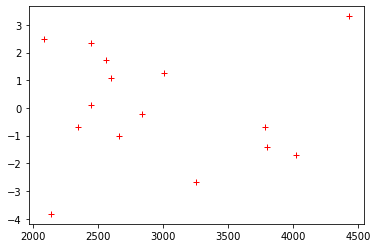

In [15]:
plt.plot(X[:,2], E, 'r+')

* The **estimated covariance matrix** for the least squares model 
$$
y_i = \beta_0 + \beta_1 x_{i,1} + \dots + \beta_{p-1} x_{i,p-1} + \epsilon_i
$$
is $S^2(B) = \mathrm{MSE} (X^t X)^{-1}$.

In [16]:
S2B = MSE * np.linalg.inv(XtX)
S2B

array([[ 5.92408244e+00,  1.01726366e-03, -1.97597095e-03],
       [ 1.01726366e-03,  3.67343974e-05, -3.34108745e-06],
       [-1.97597095e-03, -3.34108745e-06,  9.39693642e-07]])

* Theory says that if $q$ of the $\beta_k$ are jointly estimated, the confidence intervals
with coefficient $1 - \alpha$ are
$$
b_k - T \cdot s(b_k) \leq \beta_k \leq b_k + T \cdot s(b_k),
$$
where $T = t(1 - \frac{\alpha}{2q}, n - p)$.
* The value of the $T$-distribution can be found in a table, online or off-line, or again with the help of the `scipy.stats` package.

In [17]:
from scipy.stats import t
q = 2
T = t.pdf(1 - alpha/2/q, n - p)
T

0.23513586310660725

* So, when estimating $\beta_1$ and $\beta_2$ jointly, after extracting the values $s(b_k)$ as square roots of the diagonal values of the array `S2B`, we can find the *lower bounds* of the confidence intervals for the $\beta_k$ as follows.

In [18]:
SB = np.diagonal(S2B)**0.5
B[:,0] - T * SB

array([2.87233499, 0.49457492, 0.008973  ])

* And the *upper bound*:

In [19]:
B[:,0] + T * SB

array([4.01694994, 0.49742519, 0.00942887])